In [1]:
from collections import Counter
from matplotlib import pyplot as plt
import json

In [2]:
def print_counter_top(ct, N):
    ans = sorted(ct.items(), key=lambda x:x[1], reverse=True)
    for k, v in ans[:N]:
        print(v, k)
def get_counter_top(ct, N):
    ans = sorted(ct.items(), key=lambda x:x[1], reverse=True)
    for k, v in ans[:N]:
        yield k

In [3]:
def getFcallsInfo(fname, verbose=False):
    vprint = print if verbose else lambda *_,**__: None
    
    with open(fname) as f:
        raw = json.load(f)

    # Find all JS function calls
    fcalls = [x for x in raw if x['name'] == 'FunctionCall']
    fcalls_by_ids = {}
    for c in fcalls:
        key = '{}-{}'.format(c['pid'], c['tid'])
        fcalls_by_ids.setdefault(key, []).append(c)

    for k, v in fcalls_by_ids.items():
        # See https://docs.google.com/document/d/1CvAClvFfyA5R-PhYUmn5OOQtYMH4h6I0nSsKchNAySU/preview
        # It mentioned how  Duration Events work.
        # But it never confirmed that 'FunctionCall' events do not nest when pid&tid do not change
        # This confirms that they do not nest
        vprint('Checking sanity of', k)
        assert('BB' not in ''.join(x['ph'] for x in v))
        assert('EE' not in ''.join(x['ph'] for x in v))
        if v[0]['ph'] =='B':
            assert ''.join(x['ph'] for x in v[:2*(len(v)//2)]) == 'BE' * (len(v)//2)
        if v[0]['ph'] =='E':
            assert ''.join(x['ph'] for x in v[1:2*(len(v)//2 + 1) - 1]) == 'BE' * (len(v)//2)
        vprint(' + this thread checks out')
        if len(v) %2 != 0:
            vprint(' * remaining event: ', v[-1]['ph'])
    vprint('OK')
    return fcalls_by_ids

In [4]:
def fcall_time_range(fcalls, timestamp_key='ts'):
    _min = min(
        int(y.get(timestamp_key))
        for x in fcalls.values()
        for y in x
        if y.get(timestamp_key) is not None
    )
    _max = max(
        int(y.get(timestamp_key))
        for x in fcalls.values()
        for y in x
        if y.get(timestamp_key) is not None
    )
    return _min, _max

In [5]:
def getCounters(fcalls_by_ids, time_slice_size=None):
    # Aggregate info about JS Function calls
    start_time, end_time = fcall_time_range(
        fcalls_by_ids, 
        timestamp_key='ts'
    )
    num_time_slice = (end_time-start_time)//time_slice_size + 1 if time_slice_size else 1
    
    callFrames = [Counter() for _ in range(num_time_slice)]
    callFunctionNames = [Counter() for _ in range(num_time_slice)]
    callURLs = [Counter() for _ in range(num_time_slice)]

    for k, v in fcalls_by_ids.items(): 
        if v[0]['ph'] == 'E':
            if len(v) < 2:
                return None
            assert v[1]['ph'] == 'B'
            v = v[1:]
        bs = [x for i, x in enumerate(v) if i % 2 == 0]
        es = [x for i, x in enumerate(v) if i % 2 != 0]
        for b, e in zip(bs, es):
            assert b['ph'] == 'B'
            assert e['ph'] == 'E'
            info = b.get('args', {}).get('data', {})
            info2 = e.get('args', {}).get('data', {})
            assert info.get('functionName') == info2.get('functionName') \
                or (not info2.get('functionName'))
            info.update(info2)
            duration = e.get('tts') - b.get('tts')
            if not info: continue
            if type(duration) is not int: continue
                
            frame = info.get('frame')
            funcName = info.get('functionName')
            url = info.get('url')
            ts = b.get('ts')
            slice_id = (ts - start_time) // time_slice_size if time_slice_size else 0
            
            callFrames[slice_id][frame] += duration / 1e6
            callFunctionNames[slice_id][funcName] += duration / 1e6
            callURLs[slice_id][url] += duration / 1e6

    if time_slice_size:
        return callFrames, callFunctionNames, callURLs
    return callFrames[0], callFunctionNames[0], callURLs[0]

In [6]:
epsilon = 1e-5

def analyze(fname, N_top_result=5, plot_interval=int(1e6), verbose=False, log_scale=False):
    fcalls_by_ids = getFcallsInfo(fname, verbose=verbose)
    callFrames, callFunctionNames, callURLs = getCounters(fcalls_by_ids)
    
    
    # ! callFrames may be major indicator: If 'None' frame uses too much time, it's usual.
    print('----- call frames -----')
    print_counter_top(callFrames, N=N_top_result)
    print('----- func names -----')
    print_counter_top(callFunctionNames, N=N_top_result)
    print('----- called urls -----')
    print_counter_top(callURLs, N=N_top_result)
    
    print(fcall_time_range(fcalls_by_ids))
    counters = getCounters(fcalls_by_ids, time_slice_size=plot_interval)
    full_counters = getCounters(fcalls_by_ids)
    
    def plot_info(info_idx, plot_name):
        for k in get_counter_top(full_counters[info_idx], 5):
            data = []
            for c in counters[info_idx]:
                if c is None:
                    data.append(-1)
                    continue
                data.append(c.get(k, 0))
            if log_scale:
                data = np.array(data)
                data = np.log(data + epsilon)
            plt.plot(data, label=str(k)[:50])

        plt.legend()
        plt.title(plot_name)
        plt.show()
    plot_info(0, "by frame")
    plot_info(1, "by function name")
    plot_info(2, "by urls")

----- call frames -----
141.759134 None
0.13138600000000003 4A3278310ADC1F4D8DE8FE0AD4FD8528
0.002773999999999999 FDE5E38EF5D4E19DD0D2040B43FC16E9
----- func names -----
117.92003400000004 CryptonightWASMWrapper.workThrottled
23.839099999999995 CryptonightWASMWrapper.onMessage
0.05893899999999997 MinerUI.updateStats
0.03438200000000002 MinerUI.drawGraph
0.020429999999999997 _0xfe497a.(anonymous function).(anonymous function)
----- called urls -----
141.759134 blob:https://authedmine.com/ecf0db7f-3019-4468-9f71-6cfe50cffccb
0.0945649999999999 https://authedmine.com/media/miner.html?key=iPda8gvGQpMBx4aALroEhqOcYSZ9ta5C&user=CS460-testing&whitelabel=0&autostart=1&throttle=0.3&threads=&background=&text=&action=&ref=&graph=
0.036821000000000007 
0.002773999999999999 https://authedmine.com/lib/simple-ui.min.js
(558819275340, 558847304266)


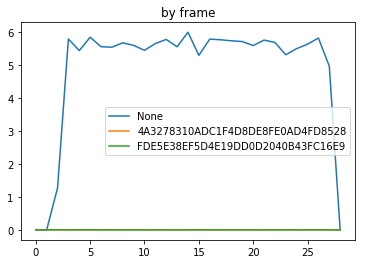

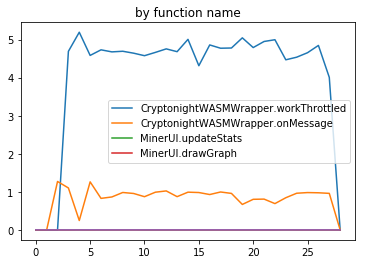

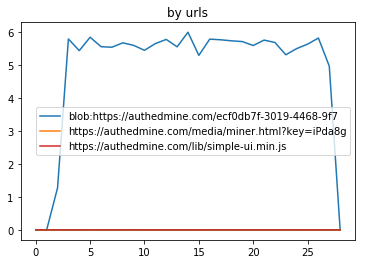

In [7]:
analyze('./miner1-tracing.json')

----- call frames -----
116.07749799999998 None
0.09576399999999986 E15AF5E14C07CC3EC5C565C90EC81B60
----- func names -----
116.07749799999998 CryptonightWASMWrapper.onMessage
0.07565199999999994 u
0.011430999999999997 JobThread.onReceiveMsg
0.006464 Miner._updateTabs
0.0013039999999999998 Miner._onMessage
----- called urls -----
116.07749799999998 blob:https://eenteslavoorsimon.be/68ddd1ce-cb24-493f-9bdb-3e0c1faf7b19
0.07565199999999994 https://eenteslavoorsimon.be/js/main.44c9d0c64f7ccf8c9c0e.js
0.02011200000000001 https://coinhive.com/lib/coinhive.min.js
(559772818515, 559802791348)


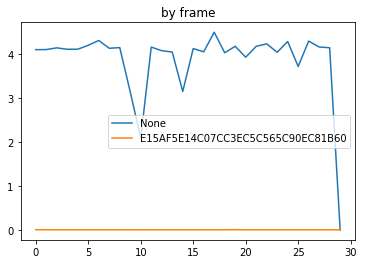

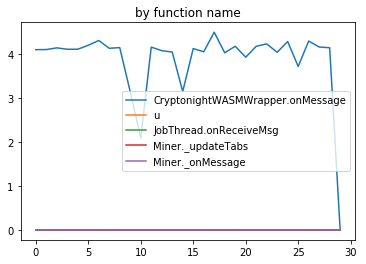

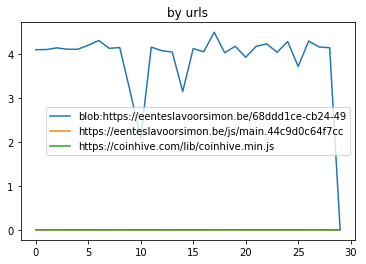

In [8]:
analyze('./miner2-tracing.json')

----- call frames -----
1.5815709999999896 967D17AB3B4B023C7BFEBA556D53B073
0.004132 None
----- func names -----
0.8633839999999995 
0.29600200000000004 F.H
0.10563299999999999 observe.characterData
0.05702000000000002 g.h.DL
0.033007000000000127 SF.C
----- called urls -----
0.7396670000000004 https://s.ytimg.com/yts/jsbin/web-animations-next-lite.min-vflqEtsI7/web-animations-next-lite.min.js
0.30061800000000016 https://s.ytimg.com/yts/jsbin/scheduler-vflYh9t8D/scheduler.js
0.2989039999999959 https://s.ytimg.com/yts/jsbin/desktop_polymer-vflbecItI/desktop_polymer.js
0.18489600000000103 https://s.ytimg.com/yts/jsbin/player-vflSawkIt/en_US/base.js
0.051093 https://s.ytimg.com/yts/jsbin/spf-vflRfjT3b/spf.js
(559122623445, 559146948536)


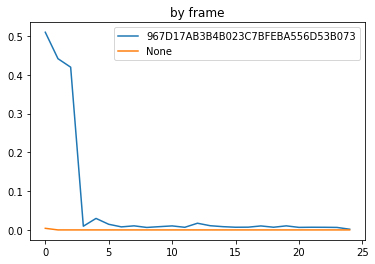

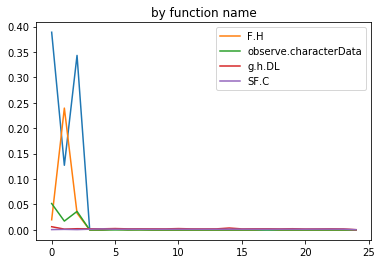

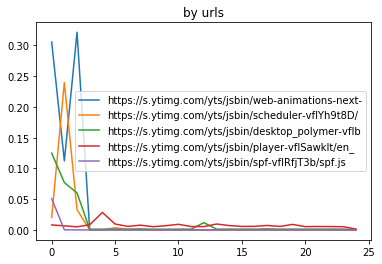

In [9]:
# Youtube can be told apart from miners by looking at callFrame[None]
analyze('./youtube1-tracing.json')

----- call frames -----
0.27787099999999915 209D8579153CE5091DB2E88AD7D93BC0
0.146941 21085C3BC727D8F2CE4128DB012F22B0
0.11231400000000001 9412A17B71DB48522F61A5AC6A58608C
0.058612 None
0.03516000000000002 CEAC92BE92E735E0A220AFB0DC22F2B3
----- func names -----
0.42844899999999947 
0.26529899999999984 nrWrapper
0.008617 run
0.005742000000000001 e.hl
0.005233999999999999 Ib.u
----- called urls -----
0.26545499999999983 https://s.abcnews.com/assets/js/newrelic.js
0.260507 https://pagead2.googlesyndication.com/pagead/js/r20180404/r20170110/osd.js
0.05293000000000002 https://tpc.googlesyndication.com/pagead/js/r20180404/r20110914/activeview/osd_listener.js
0.045881 blob:http://abcnews.go.com/e541e1a3-f1e6-49eb-a5ca-f852ebdb6316
0.029642000000000005 https://s-static.innovid.com/mobileapps/s/js/vpaid/1gk9uk?cb=690f7e00-206f-c89f-b238-df860ea9f89e&deviceid=&ivc=[ecp]
(559243891687, 559247294303)


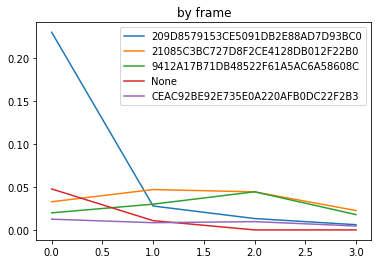

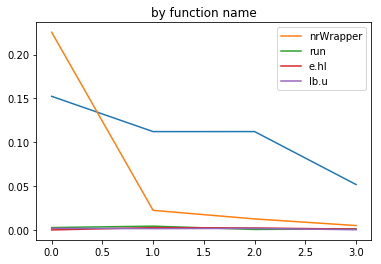

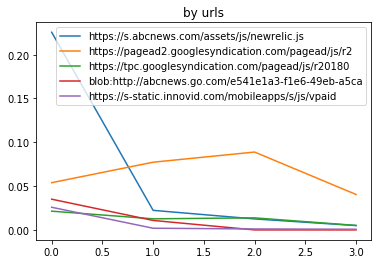

In [10]:
# this is a weird site. Most computation goes to an unamed JS function
# But it's not running anything on callFrame[None]
# Also, urls 
analyze('./news-with-ads1-tracing.json')

----- call frames -----
0.514492 A30A552FF7BDBE2507DA76F96EB28CFE
0.18246300000000001 9DD191286EB33FB0708EF31A6463FB3C
0.082672 9BF1834076D5ED752795E0BA808976B3
0.045757 7D3A51080AC8513635F8F2C834FED0FE
0.0014780000000000001 93BDA790F5466B38374C2256F83EF32F
----- func names -----
0.535039 
0.16555299999999987 at
0.045757 w
0.04126799999999999 b.socket.onmessage
0.018278 Ib.u
----- called urls -----
0.5033860000000001 http://bitcointicker.co/tickerHistv24.js?4
0.18383200000000002 https://pagead2.googlesyndication.com/pagead/js/r20180404/r20170110/osd.js
0.06403499999999998 https://googleads.g.doubleclick.net/pagead/ads?client=ca-pub-5944258550130213&output=html&h=60&slotname=8957690103&adk=4122895357&adf=1602281170&w=468&lmt=1523479226&loeid=38893312&format=468x60&url=http%3A%2F%2Fbitcointicker.co%2F&flash=0&wgl=1&adsid=NT&dt=1523479226367&bpp=13&bdt=892&fdt=17&idt=176&shv=r20180404&cbv=r20170110&saldr=aa&correlator=2727408848956&frm=20&ga_vid=720857039.1523479226&ga_sid=1523479227&ga_h

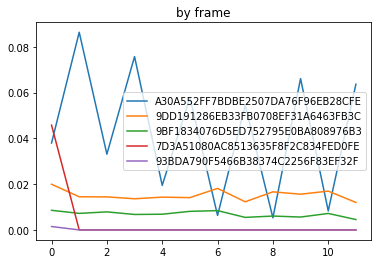

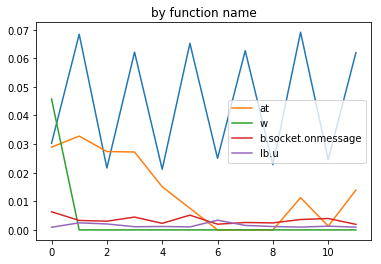

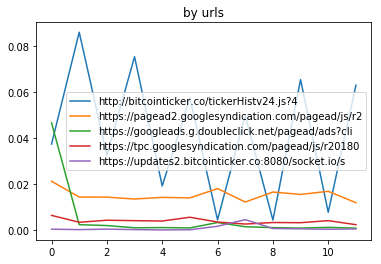

In [11]:
analyze('./realtime-apps1-tracing.json')